In [39]:
from pathlib import Path
import requests

DATA_PATH = Path("data")
PATH = DATA_PATH / "mnist"

PATH.mkdir(parents=True, exist_ok=True)

URL = "http://deeplearning.net/data/mnist/"
FILENAME = "mnist.pkl.gz"

if not (PATH/FILENAME).exists():
    content = requests.get(URL + FILENAME).content
    (PATH/FILENAME).open("wb").write(content)

In [40]:
import pickle
import gzip

with gzip.open((PATH/FILENAME).as_posix(), "rb") as f:
    ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding="latin-1")

(50000, 784)


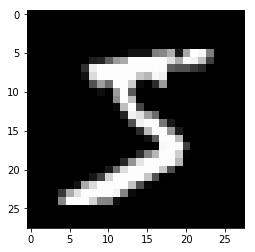

In [41]:
from matplotlib import pyplot as plt
import numpy as np

plt.imshow(x_train[0].reshape((28, 28)), cmap="gray")
print(x_train.shape)

In [42]:
import torch

x_train, y_train, x_valid, y_valid = map(
    torch.tensor, (x_train, y_train, x_valid, y_valid)
)

n, c = x_train.shape
x_train, x_train.shape, y_train.min(), y_train.max()
print(x_train, y_train)
print(x_train.shape)
print(y_train.min(), y_train.max())

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]]) tensor([5, 0, 4,  ..., 8, 4, 8])
torch.Size([50000, 784])
tensor(0) tensor(9)


In [43]:
import math

weights = torch.randn(784, 10) / math.sqrt(784)
weights.requires_grad_()

bias = torch.zeros(10, requires_grad=True)

In [44]:
def log_softmax(x):
    return x - x.exp().sum(-1).log().unsqueeze(-1)

def model(xb):
    return log_softmax(xb @ weights + bias)

In [45]:
bs = 64

xb = x_train[0:bs]
preds = model(xb)
preds[0], preds.shape
print(preds[0], preds.shape)

tensor([-2.7523, -2.3667, -1.7872, -2.9603, -2.4465, -2.0110, -1.9613, -2.1440,
        -2.6420, -2.6081], grad_fn=<SelectBackward>) torch.Size([64, 10])


In [46]:
def nll(input, target):
    return -input[range(target.shape[0]), target].mean()

loss_func = nll

In [47]:
yb = y_train[0:bs]
print(loss_func(preds, yb))

tensor(2.3278, grad_fn=<NegBackward>)


In [48]:
def accuracy(out, yb):
    preds = torch.argmax(out, dim=1)
    return (preds == yb).float().mean()
    
print(accuracy(preds, yb))


tensor(0.0469)


tensor(0.0469)


In [49]:
from IPython.core.debugger import set_trace

lr = 0.5
epochs = 2

for epoch in range(epochs):
    for i in range((n - 1) // bs + 1):
        start_i = i * bs
        end_i = start_i + bs
        xb = x_train[start_i:end_i]
        yb = y_train[start_i:end_i]
        pred = model(xb)
        loss = loss_func(pred, yb)

        loss.backward()
        with torch.no_grad():
            weights -= weights.grad * lr
            bias -= bias.grad * lr
            weights.grad.zero_()
            bias.grad.zero_()
            
print(loss_func(model(xb), yb), accuracy(model(xb), yb))

tensor(0.0827, grad_fn=<NegBackward>) tensor(1.)


### `nn.functional`
* 여러 유용한 nn모듈의 함수들을 가지고 있음

In [50]:
import torch.nn.functional as F

loss_func = F.cross_entropy

def model(xb):
    return xb @ weights + bias

In [51]:
print(loss_func(model(xb), yb), accuracy(model(xb), yb))

tensor(0.0827, grad_fn=<NllLossBackward>) tensor(1.)


### `nn.Module`
* 학습 과정을 보다 간결하고 정돈되도록 표현할 수 있음
* `nn.Module`을 상속받는 클래스를 생성한 후 forward함수를 정의하면 `.parameter()`함수나 `.zero_grad()`등의 메소드를 직접 정의하지 않아도 사용 가능함

In [52]:
from torch import nn
class Mnist_Logistic(nn.Module):
    def __init__(self):
        super().__init__()
        self.weights = nn.Parameter(torch.randn(784, 10) / math.sqrt(784))
        self.bias = nn.Parameter(torch.zeros(10))

    def forward(self, xb):
        return xb @ self.weights + self.bias

In [53]:
model = Mnist_Logistic()

print(loss_func(model(xb), yb))

tensor(2.3522, grad_fn=<NllLossBackward>)


`nn.Module`을 이용한다면 아래와 같이 훈련 과정에서 가중치를 갱신하는 부분을 더욱 간결하게 작성할 수 있다.

In [54]:
def fit():
    for epoch in range(epochs):
        for i in range((n - 1) // bs + 1):
            start_i = i * bs
            end_i = start_i + bs
            xb = x_train[start_i:end_i]
            yb = y_train[start_i:end_i]
            pred = model(xb)
            loss = loss_func(pred, yb)

            loss.backward()

            with torch.no_grad():
                # weights -= weights.grad * lr
                # bias -= bias.grad * lr
                # weights.grad.zero_()
                # bias.grad.zero_()
                for p in model.parameters():
                    p -= p.grad * lr
                model.zero_grad()

fit()

print(loss_func(model(xb), yb))

tensor(0.0809, grad_fn=<NllLossBackward>)


### `nn.Linear`
* 선형 단층 신경망 레이어를 생성하는 함수

In [55]:
class Mnist_Logistic(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin = nn.Linear(784, 10)

    def forward(self, xb):
        return self.lin(xb)

In [56]:
model = Mnist_Logistic()

print(loss_func(model(xb), yb))

tensor(2.2931, grad_fn=<NllLossBackward>)


In [58]:
fit()

print(loss_func(model(xb), yb))

tensor(0.0650, grad_fn=<NllLossBackward>)
